<a href="https://colab.research.google.com/github/Glasiermedic/Traffic-Fatality-Capstone/blob/master/Regression_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Logistic Regression-classifier comparative modeling

### 2017 FARS DATA

####Fatal accidents are an on going issue in the United States in since the advent of combustion engines. In the last decade efforts to reduce the number of fatalities in accidents across the nation has touched the automobile industry, emergency response agencies, construction industry and even the cell phone industry.   The United States National Highway Traffic Safety Administration has been collecting data through the  Fatality Analysis Reporting System to help understand what is leading to over thirty four thousand fatal accidents each year.  This project is aimed at helping to predict the likelihood that more than 50% of invididuals involved in the motor vehicle accident will be fatalities.  Using the model to predict the outcome can help to improve intersections, determine appropriate lighting and roadway prevention devices and the change to traffic laws. 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
#!pip install boruta
!pip3 install seaborn==0.9.0

#from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler 
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
#from boruta import boruta_py
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### The data froms from the FARS/NHTSA 2017 data archive.  

In [ ]:
fars = pd.read_csv("https://raw.githubusercontent.com/lbcommer/datasets/master/2017-fars-data-set-traffic-fatalities/accident.csv")

### Feature interpetation and labels and dimension

####The feature labels and their corresponding labels can be found at 

####https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/812559
####All labels are in relation to the accident data set.  The dictionaries are distributed throughout the manual.  

#### There are 34247 entries with 52 variables




In [ ]:
fars.shape

(34247, 52)

In [ ]:
fars.head()

,STATE,ST_CASE,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERNOTMVIT,PERMVIT,PERSONS,COUNTY,CITY,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,NHS,RUR_URB,FUNC_SYS,RD_OWNER,ROUTE,TWAY_ID,TWAY_ID2,MILEPT,LATITUDE,LONGITUD,SP_JUR,HARM_EV,MAN_COLL,RELJCT1,RELJCT2,TYP_INT,WRK_ZONE,REL_ROAD,LGT_COND,WEATHER1,WEATHER2,WEATHER,SCH_BUS,RAIL,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,CF1,CF2,CF3,FATALS,DRUNK_DR
0,1,10001,1,1,0,0,0,1,1,73,330,19,2,2017,1,23,35,1,2,1,1,1,I-459,NaN,10,33.335661,-87.007094,0,38,0,0,1,1,0,3,2,1,0,1,0,725409J,99,99,99,99,88,88,0,0,0,1,0
1,1,10002,1,1,0,0,0,1,1,89,1730,14,2,2017,3,14,59,1,2,1,1,1,I-565,NaN,70,34.661528,-86.786853,0,1,0,0,1,1,0,3,1,1,0,1,0,0000000,15,0,15,9,88,88,0,0,0,1,0
2,1,10003,3,3,0,0,0,3,3,101,2130,31,1,2017,3,20,31,1,2,1,1,1,I-85,CHANTILLY PKWY,100,32.366519,-86.145281,0,12,1,0,1,1,0,1,2,1,0,1,0,0000000,99,99,99,99,88,88,0,0,0,1,0
3,1,10004,1,1,0,0,0,1,1,73,350,1,1,2017,1,16,55,0,2,4,4,6,20TH ST ENSLEY,AVE I,0,33.510175,-86.894003,0,30,0,0,3,2,0,4,3,2,0,2,0,0000000,99,99,16,58,88,88,20,0,0,1,0
4,1,10005,1,1,0,0,0,2,2,13,0,1,1,2017,1,20,0,1,1,1,1,1,I-65,NaN,1383,31.947236,-86.556778,0,35,0,0,1,1,0,3,2,2,0,2,0,0000000,20,17,20,31,21,11,0,0,0,1,0


#### There are several variables that are categorical like city state and route identifiers that add no predictive value to the our model.  We have removed the state, state crash ID, City, County, Traffic way ID, and Traffic Way ID#2.  

In [ ]:
fars =fars.drop(['STATE', 'ST_CASE', 'CITY', 'COUNTY', 'TWAY_ID', 'TWAY_ID2'], axis = 1)


### Evaluation of metric Precursors

####  First we will examine "FATALS" to see how the number of fatalities reported is distributed.   We will utilize "FATALS", "PERSONS" and "PEDS" to create a ratio of fatalities and the number of individuals involved, this variable will be called  "fatals_to_pers".  Since we are interested in a threshold of 50% we will also convert the newly created "fatals_to_pers" variable into a binary variable called 'fatal_ratio_great_half'

In [ ]:
#FATALS is the number of people involved who were reported to have died on the scene or at the hospital. 
fars.FATALS.value_counts()

1     31913
2      1927
3       302
4        76
5        25
6         3
13        1
Name: FATALS, dtype: int64

In [ ]:
#PEDS is the number of people not in a motor vehicle that were reported. 
fars['PEDS'].value_counts()

0     27338
1      6513
2       319
3        44
4        15
5        12
7         2
23        1
10        1
9         1
6         1
Name: PEDS, dtype: int64

In [ ]:
# PERSONS is the number of people in a motor vehicle (moving or parked) that were reported
fars['PERSONS'].value_counts()

1     14171
2      9598
3      4949
4      2499
5      1365
6       706
7       391
8       213
9       114
10       75
11       39
0        35
12       25
13       13
16       10
14        9
15        8
17        7
18        3
19        3
20        3
24        2
42        1
47        1
48        1
40        1
26        1
50        1
21        1
23        1
29        1
Name: PERSONS, dtype: int64

In [ ]:
fars['total_pers_involved'] = fars['PEDS'] + fars['PERSONS']

In [ ]:
fars['fatals_to_pers_'] = fars['FATALS'] / fars['total_pers_involved']

In [ ]:
#fars['fatals_to_pers_'].value_counts()

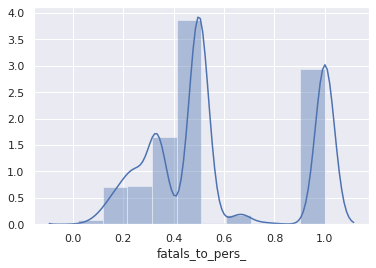

In [ ]:
sns.distplot(fars['fatals_to_pers_'], bins=10)
plt.show()

#### 12,971  fatal accidents had 50% of the individuals involved die.  

#### 10,615 fatal accidents had less than 50% of the individuals involved die. 

#### 10,661 fatal accidents had over 50% of individuals involved die. 

In [ ]:
# all three values can be obtained by changing the bolean portion of this code between '==','<','>'
fars['fatals_to_pers_'].loc[np.where((fars['fatals_to_pers_'])==.5)].count()

12971

In [ ]:
fars['fatal_ratio_great_half'] = fars['fatals_to_pers_'].apply(lambda x: x > .5)*1

In [ ]:
fars.loc[0:, 'fatals_to_pers_':'fatal_ratio_great_half'].head(10)

,fatals_to_pers_,fatal_ratio_great_half
0,1.000000,1
1,1.000000,1
2,0.333333,0
3,1.000000,1
4,0.500000,0
5,0.250000,0
6,0.500000,0
7,1.000000,1
8,1.000000,1
9,0.500000,0


In [ ]:
fars.loc[0:, 'fatals_to_pers_':'fatal_ratio_great_half'].describe()

,fatals_to_pers_,fatal_ratio_great_half
count,34247.000000,34247.000000
mean,0.578684,0.311297
std,0.289706,0.463031
min,0.020833,0.000000
25%,0.333333,0.000000
50%,0.500000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


### Resulting Metric: 

#### WE now have the variable 'fatal_ratio_great_half' which we will use as our metric for our project.

In [ ]:
#fars['fatal_ratio_great_half'].head(30)

In [ ]:
fars['fatal_ratio_great_half'].value_counts()

0    23586
1    10661
Name: fatal_ratio_great_half, dtype: int64

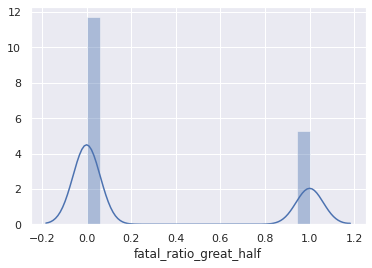

In [ ]:
sns.distplot(fars['fatal_ratio_great_half'])

#### Removing the fields that we utilized as part of the calculation for the metric variable. 

In [ ]:
fars = fars.drop(['PEDS', 'FATALS', 'PERSONS', 'PERNOTMVIT', 'PERMVIT'],axis = 1)

#### Converting a categorical variable tracking the exact railroad crossing associated with the accident, if any or known, into a variable that indicates if there was a railroad crossing or not. 

In [ ]:
for i in range(0,len(fars['RAIL'])):
  if (fars['RAIL'][i]) == '0000000' or (fars['RAIL'][i]) == '9999999':
    fars.at[i,'RAIL']= 0
  else: 
    fars.at[i,'RAIL']= 1
    
fars['RAIL'] =fars['RAIL'].astype('int')   
    
    



In [ ]:
fars['RAIL'].value_counts()

0    34127
1      120
Name: RAIL, dtype: int64

#### Checking to make sure all variables are now integers or floats to accomodate machine learning models. 

In [ ]:
fars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34247 entries, 0 to 34246
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VE_TOTAL                34247 non-null  int64  
 1   VE_FORMS                34247 non-null  int64  
 2   PVH_INVL                34247 non-null  int64  
 3   DAY                     34247 non-null  int64  
 4   MONTH                   34247 non-null  int64  
 5   YEAR                    34247 non-null  int64  
 6   DAY_WEEK                34247 non-null  int64  
 7   HOUR                    34247 non-null  int64  
 8   MINUTE                  34247 non-null  int64  
 9   NHS                     34247 non-null  int64  
 10  RUR_URB                 34247 non-null  int64  
 11  FUNC_SYS                34247 non-null  int64  
 12  RD_OWNER                34247 non-null  int64  
 13  ROUTE                   34247 non-null  int64  
 14  MILEPT                  34247 non-null

#### A function has been created to allow for finetuning of features based on correlation with each other. 

In [ ]:
def corr_dataframe(dataframe,decimal_percentage):
  correlated_features = set()  
  correlation_matrix = dataframe.corr()
  for i in range(len(correlation_matrix .columns)):  
      for j in range(i):
          if abs(correlation_matrix.iloc[i, j]) < decimal_percentage and i!= j:
              colname = correlation_matrix.columns[i]
              correlated_features.add(colname)
  #print(correlation_matrix)
  print("the dimensions of the dataframe are:{} when we set the precentage to %{}".format(dataframe.shape,decimal_percentage*100))
  print(correlated_features) 
  print(len(correlated_features))
  return correlated_features

#### Created a ten fold split in data to allow for a more robust cross validation for all models used

In [ ]:
kfolds = StratifiedShuffleSplit(n_splits =10, random_state=1)

#### An RFECV (recursive feature elimination and cross-validated selection) as another method of choosing features to exclude from the models to help eliminate noise from the model. This function has a very high computational cost and was not used in the end but is included for use or alteration should the stakeholders decide that a higher accuracy or other measure was wanted.  

In [ ]:
%%time
#estimator = SVR(kernel="linear")

#selector = RFECV(estimator, step=1, cv=kfolds)
#selector.fit(fars.drop(['VE_TOTAL_of1'], axis=1),fars['VE_TOTAL_of1'])
#selector.support_ 

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [ ]:
X = fars.drop(['fatal_ratio_great_half'],axis =1)
y = fars['fatal_ratio_great_half'] 
y.shape
print (X.shape)

(34247, 43)


#### We will utilize a Random Forest Classifier to determine which features will best help our models.  We will also run a seperate Random Forest algorithm as a comparison for the logistic regression, ridge and lasso algorithms. 

In [ ]:


rfc = ensemble.RandomForestClassifier() 

 
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=7, random_state = 1)
 
forest.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:

forest.feature_importances_
forest.score(X,y)

1.0

In [ ]:
fars.shape[1]

44

### Feature Importance:
#### We now have a list and a graph of the features that the Random Forest Model calculated to be the most important in predicting the target values for our metric.

Top Ten Feature Ranking:
1. VE_TOTAL (0.421722426639269)
2. VE_FORMS (0.30053296170644406)
3. PVH_INVL (0.06893455071860767)
4. DAY (0.066636721177484)
5. MONTH (0.05731129696992764)
6. YEAR (0.02116114442889055)
7. DAY_WEEK (0.012494258558141982)
8. HOUR (0.011247928752631068)
9. MINUTE (0.007812278911710565)
10. NHS (0.00742987330585936)


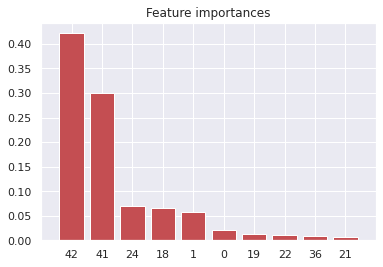

CPU times: user 5.31 s, sys: 577 ms, total: 5.89 s
Wall time: 12 s


In [ ]:
%%time
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=7, random_state = 1)
 
forest.fit(X,y)


importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]
imp_feat = []
print("Top Ten Feature Ranking:")

for f in range(X.shape[1]):
    imp_feat.append(fars.columns[f])
for f in range (0,10):
    print("{}. {} ({})".format(f + 1, fars.columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,10), importances[indices][:10],
       color="r", yerr=std[indices][:10], align="center")
plt.xticks(range(0,10), indices[:10])
plt.xlim([-1, 10])
plt.show()

### Target Metric vs. Selected features

#### For each feature a scatter plot against the target metric reveals how the target metric is related to the feature. 


In [ ]:
feat_imp =imp_feat[:10]

fars_feat = fars[feat_imp]


<Figure size 1080x360 with 0 Axes>

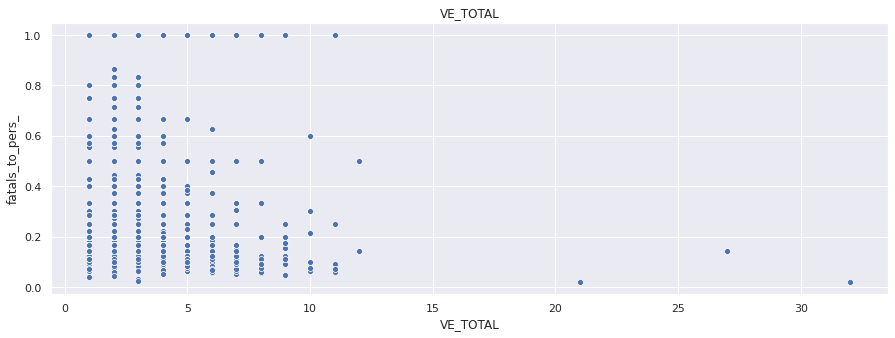

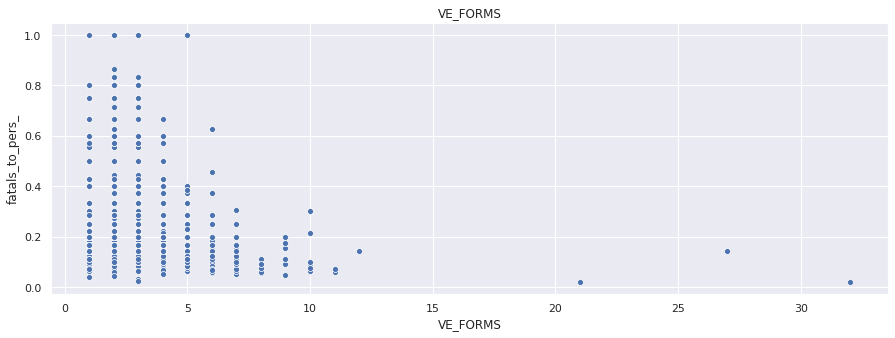

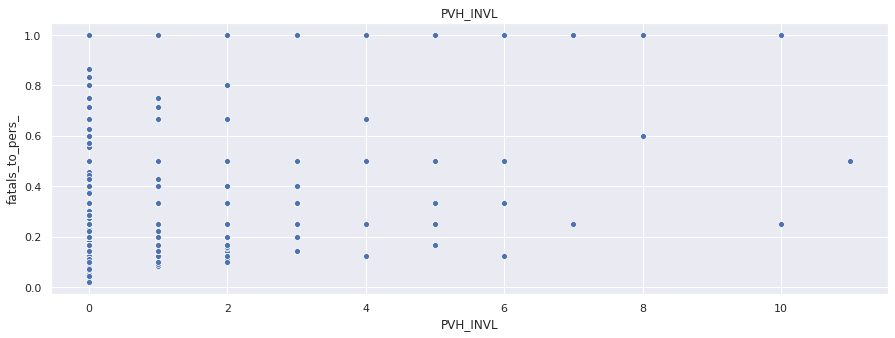

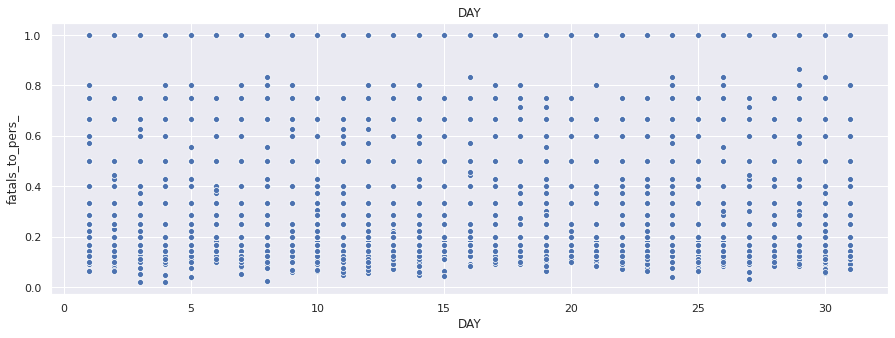

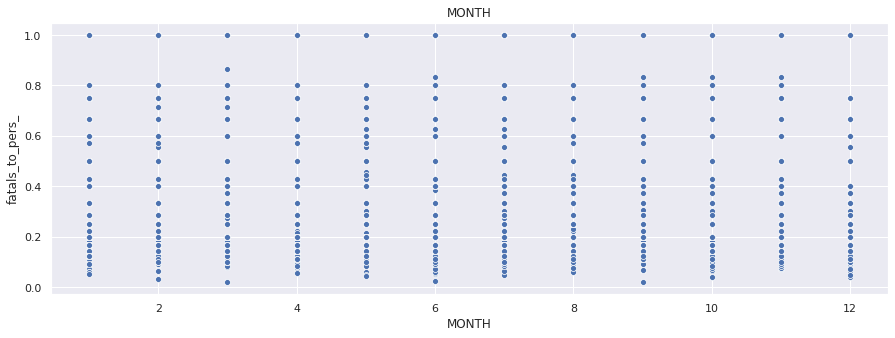

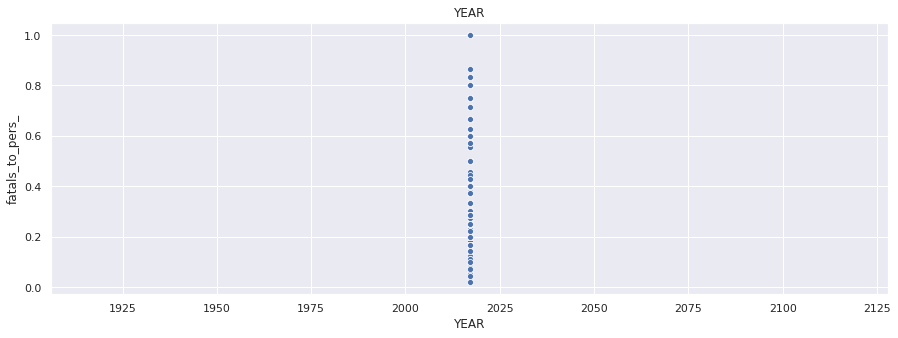

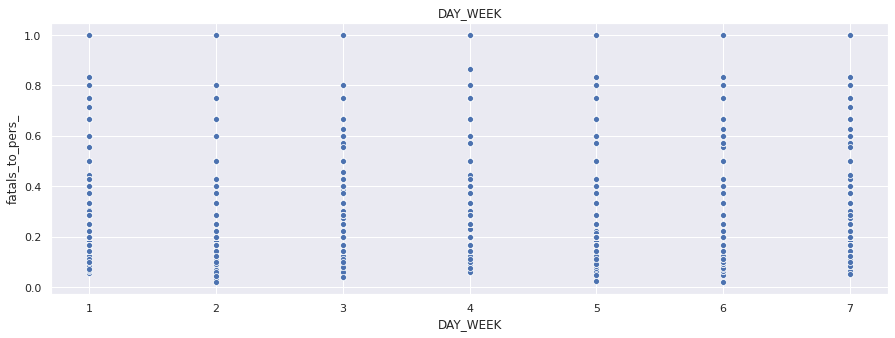

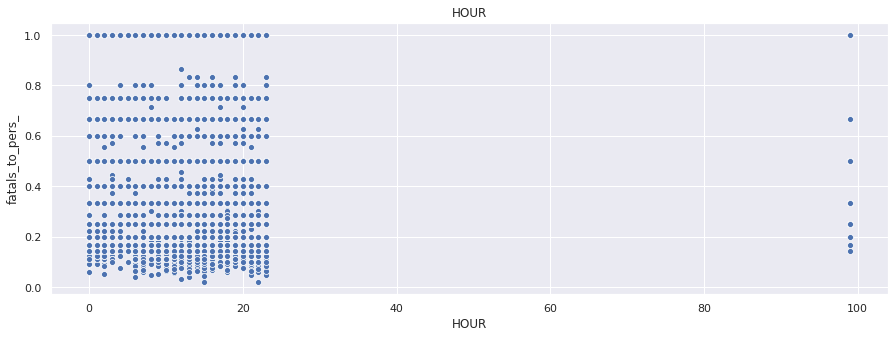

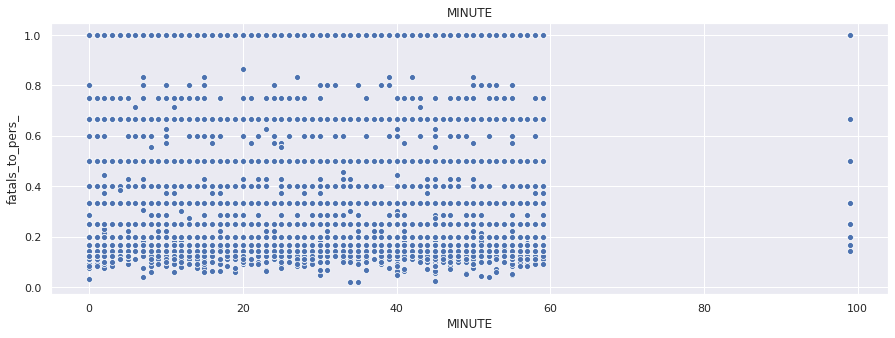

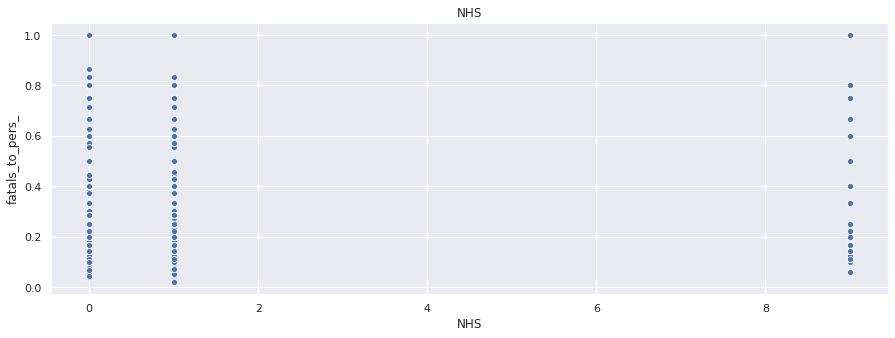

CPU times: user 4.54 s, sys: 990 ms, total: 5.53 s
Wall time: 4.42 s


In [ ]:
%%time

plt.figure(figsize=(15,5))
for item in fars_feat.columns:
  plt.figure(figsize=(15,5))
  sns.scatterplot(x =fars_feat[item], y = fars['fatals_to_pers_'])
  plt.title(item)
  plt.show()



In [ ]:
fars_feat.NHS.value_counts()

0    20241
1    13086
9      920
Name: NHS, dtype: int64

### Variance

#### We do have a large amount of variance in our feaures so we will apply a min/max scaler.  Logistic regression and many other algorithms perform better if the features are similar in their range of their values.  

In [ ]:
fars_feat.var()

VE_TOTAL      0.695367
VE_FORMS      0.625192
PVH_INVL      0.082732
DAY          77.064411
MONTH        11.362991
YEAR          0.000000
DAY_WEEK      4.338479
HOUR        103.206686
MINUTE      339.384989
NHS           2.168901
dtype: float64

In [ ]:
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
fars_feat_scal = scaler.fit_transform(fars_feat)

In [ ]:
fars_feat_scal.shape


(34247, 10)

#### Testing how the correlation of features after determining their importance in calculating the primary metric, the outcomes using less than 50% correlated (7 feature left), 10% correlated (7 features left), 5% correlated (7 features left), 1% correleated (6 features left) were generated.  For our model we attempted to utilize the 1% list, the 50% list and .05% list.  For each of the four models we chose using the correlation lists resulted in lower recall for . 

In [ ]:
#corrlist_1_per =list(corr_dataframe(fars_feat_scaldf,.01))
#corrlist_50_per =list(corr_dataframe(fars_feat_scaldf,.5))
#corrlist_p05_per =list(corr_dataframe(fars_feat_scaldf,.0005))

In [ ]:
#data_corr = fars_feat_scaldf[corrlist_p05_per]
#data_corr_all = fars_feat_scal[corrlist_p05_per]

### Training and Testing

#### The data is then split into 80% training and 20% testing to allow for more reliable results. 



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fars_feat_scal, y, test_size=0.2, random_state=1)

### Random Forest: Cross Validation and Kfolds

In [ ]:
kfolds = StratifiedShuffleSplit(n_splits =5, random_state=1)

In [ ]:
forest = RandomForestClassifier( n_jobs=-1, class_weight='balanced', n_estimators = 500, max_features = 7, max_depth=12, random_state = 1)

print(cross_val_score(forest,X_train, y_train, cv=kfolds, scoring = 'recall', verbose = 1))
pred_y_sklearn =cross_val_predict(forest, X_test, y_test, cv=10)
y_true = y_test
y_pred = cross_val_predict(forest, X_test, y_test, cv=10)
print('\n Confusion Matrix')
#print(\n confusion_matrix(y_pred, y_true))
print(pd.crosstab(pred_y_sklearn, y_test))
print("")
print(classification_report(y_pred, y_true))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


[0.7932243  0.80023364 0.79672897 0.82476636 0.79906542]

 Confusion Matrix
fatal_ratio_great_half     0     1
row_0                             
0                       3463   629
1                       1285  1473

              precision    recall  f1-score   support

           0       0.73      0.85      0.78      4092
           1       0.70      0.53      0.61      2758

    accuracy                           0.72      6850
   macro avg       0.72      0.69      0.69      6850
weighted avg       0.72      0.72      0.71      6850



#### looking at the split of the data we can see there is a ratio of 1:2 

In [ ]:
y.value_counts()

0    23586
1    10661
Name: fatal_ratio_great_half, dtype: int64

In [ ]:
clf = LogisticRegressionCV(Cs =1, cv=kfolds, random_state =1, max_iter = 1000, class_weight ='balanced',scoring='recall')
clf_lasso = LogisticRegressionCV(Cs =1, cv=kfolds, random_state =1, max_iter = 1000, penalty='l2', class_weight='balanced', scoring='recall')
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state = 1)




In [ ]:
%%time
parameters = {'max_depth': [3,6,7], 'n_estimators' : [50, 150, 200], 'max_features' : [7]}
 
forest_grid = GridSearchCV(forest, parameters, cv=kfolds, scoring='recall')
forest_grid.fit(X_train, y_train)

CPU times: user 16.7 s, sys: 1.65 s, total: 18.3 s
Wall time: 1min 27s


## Random Forest with cross validation and Kfolds

#### Using gridsearch the best parameters for the Random Forest algorithm have been determined and utilized.  

In [ ]:
forest_grid.best_params_

{'max_depth': 3, 'max_features': 7, 'n_estimators': 50}

In [ ]:
%%time
print(cross_val_score(forest_grid,X_train, y_train, cv=kfolds))


[0.89602804 0.9135514  0.9228972  0.92873832 0.91471963]
CPU times: user 1min 16s, sys: 7.68 s, total: 1min 24s
Wall time: 6min 43s


In [ ]:
%%time
y_true = y_test
y_pred = cross_val_predict(forest_grid, X_test, y_test, cv=10)
print('\n Confusion Matrix')
#print(\n confusion_matrix(y_pred, y_true))
print(pd.crosstab(y_pred, y_test))
print(forest_grid.score(X_test, y_test))
print("")
print(classification_report(y_pred, y_true))


 Confusion Matrix
fatal_ratio_great_half     0     1
row_0                             
0                       2803   179
1                       1945  1923
0.9157944814462416

              precision    recall  f1-score   support

           0       0.59      0.94      0.73      2982
           1       0.91      0.50      0.64      3868

    accuracy                           0.69      6850
   macro avg       0.75      0.72      0.68      6850
weighted avg       0.77      0.69      0.68      6850

CPU times: user 1min 52s, sys: 12.2 s, total: 2min 4s
Wall time: 5min 20s


## Logistic Regression with cross vailidation and kfolds

#### A basic Logistic Regression without fine tuning any parameters. 

In [ ]:
%%time

fit = clf.fit(X_train, y_train)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
pred_y_sklearn = clf.predict(X_test)
y_true = y_test
y_pred = clf.predict(X_test)
#print('\n Accuracy by admission status')
print(confusion_matrix(y_pred, y_true))
#print(pd.crosstab(pred_y_sklearn, y_test))
print(pred_y_sklearn.shape)
print('\n Percentage Recall')
print(clf.score(X_test, y_test))
print(classification_report(y_pred, y_true))

Coefficients
[[-0.01400684 -0.01417173  0.0004647   0.00034688 -0.00137323  0.
  -0.00540368 -0.00068342  0.00251354 -0.01569872]]
[0.00409785]
[[2548  848]
 [2200 1254]]
(6850,)

 Percentage Recall
0.5965746907706946
              precision    recall  f1-score   support

           0       0.54      0.75      0.63      3396
           1       0.60      0.36      0.45      3454

    accuracy                           0.56      6850
   macro avg       0.57      0.56      0.54      6850
weighted avg       0.57      0.56      0.54      6850

CPU times: user 403 ms, sys: 246 ms, total: 649 ms
Wall time: 382 ms


## Lasso Regression model with cross validation

#### Basic Lasso model. 

In [ ]:
%%time
fit = clf_lasso.fit(X_train, y_train)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
y_true = y_test
y_pred = clf_lasso.predict(X_test)

#print(confusion_matrix(y_pred, y_true))
print(pd.crosstab(y_pred, y_test))
print(y_pred.shape)
print('\n Percentage recall')
print(clf_lasso.score(X_test, y_test))
print(classification_report(y_pred, y_true))

Coefficients
[[-0.01400684 -0.01417173  0.0004647   0.00034688 -0.00137323  0.
  -0.00540368 -0.00068342  0.00251354 -0.01569872]]
[0.00409785]

 Accuracy by admission status
fatal_ratio_great_half     0     1
row_0                             
0                       2548   848
1                       2200  1254
(6850,)

 Percentage accuracy
0.5965746907706946
              precision    recall  f1-score   support

           0       0.54      0.75      0.63      3396
           1       0.60      0.36      0.45      3454

    accuracy                           0.56      6850
   macro avg       0.57      0.56      0.54      6850
weighted avg       0.57      0.56      0.54      6850

CPU times: user 465 ms, sys: 322 ms, total: 788 ms
Wall time: 413 ms


## Ridge Regression model with cross validation

#### Basic Ridge Regression model. 

In [ ]:
%%time
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1], class_weight='balanced', cv=kfolds)
ridge.fit(X_train,y_train)
scores = cross_val_score(ridge, X_train, y_train, cv=kfolds, scoring = 'recall')

#ridgeregcv = RidgeCV(alphas=.35, cv = kfolds) 
#ridgeregcv.fit(X_train, y_train)
#print(ridgeregcv.score(X_train, y_train))
#origparams = ridgeregcv.coef_[0]
#print(origparams)
print(scores)
print("Recall: {} (+/- {})".format(scores.mean(), scores.std() * 2))

[0.87266355 0.90186916 0.90186916 0.9088785  0.90420561]
Recall: 0.8978971962616823 (+/- 0.025747621147581175)
CPU times: user 2.7 s, sys: 1.67 s, total: 4.36 s
Wall time: 2.57 s


## Ridge Regression Model with cross validation and Kfolds 

#### Ridge Gressgion fine tuned using Gridsearch

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
ridge2 = RidgeClassifier(class_weight='balanced')

a_list = [.01, .1, .02, .2, .03, 0.3, .04, .4, .05, .5, .06, .6, .07,.7, .08, .8, .09, .9, .1]
alpha_list = a_list*2

parameters = {'alpha': alpha_list,
                    'fit_intercept': [True,False], 
                    'normalize' :[False, True]}
ridge_grid = GridSearchCV(ridge2, parameters, cv=kfolds, scoring='recall')
ridge_grid.fit(X_train, y_train)


CPU times: user 22.8 s, sys: 17.6 s, total: 40.4 s
Wall time: 20.6 s


In [ ]:
#alpha_list

In [ ]:
ridge_grid.score(X_test, y_test)

0.9091341579448144

In [ ]:
ridge_grid.best_score_ 

0.9065420560747663

In [ ]:
ridge_grid.best_params_

{'alpha': 0.01, 'fit_intercept': False, 'normalize': False}

In [ ]:
pred_y_sklearn = ridge_grid.predict(X_test)
y_true = y_test
y_pred = ridge_grid.predict(X_test)
#print(confusion_matrix(y_pred, y_true))
print(pd.crosstab(pred_y_sklearn, y_test))
print(y_pred.shape) 
print('\n precentage recall')
print(ridge_grid.score(X_test, y_test))
print(classification_report(y_pred, y_true))

fatal_ratio_great_half     0     1
row_0                             
0                       2835   191
1                       1913  1911
(6850,)

 precentage recall
0.9091341579448144
              precision    recall  f1-score   support

           0       0.60      0.94      0.73      3026
           1       0.91      0.50      0.64      3824

    accuracy                           0.69      6850
   macro avg       0.75      0.72      0.69      6850
weighted avg       0.77      0.69      0.68      6850



### Conclusion 
####  Using Random Forest with cross validation and the optimized parameters from grid search produces the best prediction model, with an recall of 91%.  Using this prediction model we can identify high risk scenarios and adjust driving practices and traffic engineering to reduce the loss of life in car accidents.  One area of improvement could be the modification of driving behavior for self/assisted driving vehicles on specific days/times of the year.  